In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# the additional functinos

def random_choice(val1, val2, p):  # p-> Probability of occurring val1
    if np.random.random() < p:
        return val1
    else:
        return val2

def InitialCondition1(N, Q, matrix):
    ct = 0
    while ct < Q:
        index = np.random.randint(0, N - 1)
        if matrix[index][0] == 1:
            continue
        else:
            matrix[index][0] = 1
            ct += 1

    return matrix

def InitialCondition2(N, Q, matrix):
    """
    This function randomly chooses infected nodes
    :param N: No. of nodes
    :param Q: No. of infected nodes
    :param matrix: the Matrix of infected and alerted nodes
    :return:
    """
    ct = 0
    while ct < Q:
        index = np.random.randint(0, N - 1)
        if matrix[index][0] == 1:
            continue
        else:
            matrix[index][0] = 1
            ct += 1
    matrix[:, 2] = 1 - matrix[:, 0] - matrix[:, 1]  # It'll be better to rewrite

    return matrix

def my_matrix(probability, matrix, N):
    for i in range(N):
        for j in range(i+1,N):
            if matrix.item(i, j) == 1:
                num = random_choice(-1, 1, probability)
                matrix.itemset((i, j), num)
                matrix.itemset((j, i), num)

    return matrix

def my_separate(matrix):
    m, n = matrix.shape
    k = np.zeros((m, 2))
    for i in range(m):
        for j in range(n):
            if matrix.item(i, j) == 1:
                k[i, 0] += 1
            elif matrix.item(i, j) == -1:
                k[i, 1] += 1

    return k[:, 0], k[:, 1]

def transition_random_walk(k_plus, k_minus, matrix):
    ki = k_plus + k_minus
    m, n = matrix.shape
    transition_matrix = matrix
    for i in range(m):
        for j in range(n):
            # Case (a)
            if k_minus[i] > 0:
                if matrix.item(i, j) == 1:
                    num = (1 - 1 / (ki[i] ** 2)) * (1 / k_plus[i])
                    transition_matrix.itemset((i, j), num)
                elif matrix.item(i, j) == -1:
                    num = 1 / (ki[i] ** 2 * k_minus[i])
                    transition_matrix.itemset((i, j), num)
                else:
                    transition_matrix.itemset((i, j), 0)
            # Case (b)
            else:
                if matrix.item(i, j) == 1:
                    num = 1 / ki[i]
                    transition_matrix.itemset((i, j), num)

    return transition_matrix


def save_data(np_array, name_of_file):
    np_array.tofile(name_of_file)

    
def load_data(name_of_file, dtype, shape):
    arr = np.fromfile(name_of_file, dtype=dtype)
    return np.reshape(arr, shape)

In [9]:
# The analytica solving of ODE using 4th order Runge-Kutta
def solve(param, N, adj_matrix, q=3, h=0.1, tmax=25, draw=False):
    """
    :param param: dict of parameters like a beta_0, delta and etc
    :param q: the number of infected. By default it is 3 number of nodes.
    :param node: ____
    :param N: Total number of nodes
    :param h: step-size
    :param tmax: maximum time
    :param draw: boolean var. for asking permission for drawing the graph
    :return: None
    """

    a = np.zeros((N, 2))
    a = InitialCondition1(N, q, a)
    reps, t = 0, 0
    t_graph, s_graph, i_graph, a_graph = [], [], [], []
    beta_0 = param['beta_0']
    beta_alpha = param['beta_alpha']
    kappa = param['kappa']
    delta = param['delta']

    while t < tmax:

        for i in range(N):
            sum1 = 0

            for j in range(N):
                sum1 += adj_matrix.item((i, j)) * a[j][0]

            def fun_I(I, A=a[i][1]): # function for infection rate
                return beta_0 * (1 - I - A) * sum1 + beta_alpha * A * sum1 - delta * I

            def fun_A(A, I=a[i][0]): # function for alert rate
                return kappa * (1 - I - A) * sum1 - beta_alpha * A * sum1

            ki1 = fun_I(a[i][0])
            ki2 = fun_I(a[i][0] + 1 / 2 * ki1 * h)
            ki3 = fun_I(a[i][0] + 1 / 2 * ki2 * h)
            ki4 = fun_I(a[i][0] + ki3 * h)
            a[i][0] += (ki1 + 2 * ki2 + 2 * ki3 + ki4) * h / 6

            kr1 = fun_A(a[i][1])
            kr2 = fun_A(a[i][1] + 1 / 2 * kr1 * h)
            kr3 = fun_A(a[i][1] + 1 / 2 * kr2 * h)
            kr4 = fun_A(a[i][1] + kr3 * h)
            a[i][1] += (kr1 + 2 * kr2 + 2 * kr3 + kr4) * h / 6

        #infected_avg = a[:, 0].mean()
        #alerted_avg = a[:, 1].mean()
        #if (infected_avg + alerted_avg) > 1:
            # print("NonValid in time {}".format(t))
            
        # Here, a[0][0] -> the state of node 0
        t_graph.append(t)
        i_graph.append(a[0][0])
        a_graph.append(a[0][1])
        s_graph.append(1 - a[0][1] - a[0][0])

        t += h
        
    return t_graph, i_graph, s_graph, a_graph


In [10]:
# the Monte Carlo simulation function

def MonteCarlo(param, N, adj_matrix, q=3, node=0, h=0.1, tmax=25, draw=False, Nsim = 10):
    """
    :param param: dict of parameters like a beta_0, delta and etc
    :param q: the number of infected. By default it is 3 number of nodes.
    :param node: ____
    :param N: Total number of nodes
    :param h: step-size
    :param tmax: maximum time
    :param draw: boolean var. for asking permission for drawing the graph
    :return: None
    """
    
    points = int(tmax/h)
    time = np.zeros((Nsim, points))
    sim = np.zeros((Nsim, points, 3))

    for k in range(Nsim):
        a = np.zeros((N, 3))
        a = InitialCondition2(N, q, a)
        t = 0
        t_graph, s_graph, i_graph, a_graph = [], [], [], []
        beta_0 = param['beta_0'] * h
        beta_alpha = param['beta_alpha'] * h
        kappa = param['kappa'] * h
        delta = param['delta'] * h

        while t < tmax:

            # a[:, 0] -> infected (pi)
            # a[:, 1] -> alerted (qi)
            # a[:, 2] -> susceptible (si)

            for i in range(N):
                sum1 = 0
                r = np.random.rand()
                for j in range(N):
                    sum1 += adj_matrix.item((i, j)) * a[j][0]

                if a[i][2] == 1:
                    if r < beta_0 * sum1:
                        a[i][0] = 1
                        a[i][1] = a[i][2] = 0
                    else:
                        if r < (kappa * sum1 + beta_0 * sum1):
                            a[i][1] = 1
                            a[i][0] = a[i][2] = 0
                        else:
                            a[i][2] = 1
                            a[i][0] = a[i][1] = 0

                elif a[i][0] == 1:
                    if r < delta:
                        a[i][2] = 1
                        a[i][1] = a[i][0] = 0
                    else:
                        a[i][0] = 1
                        a[i][1] = a[i][2] = 0

                elif a[i][1] == 1:
                    if r < beta_alpha * sum1:
                        a[i][0] = 1
                        a[i][1] = a[i][2] = 0
                    else:
                        a[i][1] = 1
                        a[i][0] = a[i][2] = 0


                # a[i][0] = fun_I(a[i][0])
                # a[i][1] = fun_A(a[i][1])
                # a[i][2] = (1 - a[i][0] - a[i][1])
            t_graph.append(t)
            i_graph.append(sum(a[:, 0])/N)  # Densities of each compartment
            a_graph.append(sum(a[:, 1])/N)
            s_graph.append(sum(a[:, 2])/N)
            t += h

        print("NO. of simulation: {}".format(k+1))
        time[k][:] = t_graph
        sim[k][:, 0] = i_graph
        sim[k][:, 1] = a_graph
        sim[k][:, 2] = s_graph

    i_av = sum(sim[:, :, 0]) / Nsim
    a_av = sum(sim[:, :, 1]) / Nsim
    s_av = sum(sim[:, :, 2]) / Nsim

    if draw:
        plt.plot(t_graph, s_av, label="S(t)", color='b')
        plt.plot(t_graph, i_av, label="I(t)", color='r')
        plt.plot(t_graph, a_av, label="A(t)", color='g')
        plt.show()

    return t_graph, i_av, s_av, a_av

### Erdos Renyi Graph

In [29]:
# Below it is unsigned graph
params = {'beta_0': 0.01, 'beta_alpha': 0.005, 'kappa': 0.2, 'delta': 0.1}
N = 320
G = nx.erdos_renyi_graph(N, 0.3)  # 0.3 stands for probability of connection
adj = nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).todense()
adj_matrix = nx.to_numpy_matrix(G, nodelist=[i for i in range(N)])

# Making signed graph from initialized network
p = 0.05  # probability of negative connection
adj_matrix = my_matrix(p, adj_matrix, N)
k_plus, k_minus = my_separate(adj_matrix)

# Transition random walk. Defining T-matrix
transition_matrix = transition_random_walk(k_plus, k_minus, adj_matrix)

Obtaining a analytical solution. 
params = {'beta_0': 3, 'beta_alpha': 2, 'kappa': 5, 'delta': 1}
t_an, i_an, s_an, a_an = solve(param=params, N=N, adj_matrix=adj_matrix, q=int(N*0.02), draw=False)

# Obtaining Monte-Carlo simulation results
t, i_mon, s_mon, a_mon = MonteCarlo(param=params, N=N, adj_matrix=adj_matrix, q=int(N * 0.02), draw=False, Nsim=100)


NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
NO. of simulation: 31
NO. of simulation: 32
NO. of simulation: 33
NO. of simulation: 34
NO. of simulation: 35
NO. of simulation: 36
NO. of simulation: 37
NO. of simulation: 38
NO. of simulation: 39
NO. of simulation: 40
NO. of simulation: 41
NO. of simulation: 42
NO. of simulation: 43
NO. of simulation: 44
NO. of simulation: 45
NO. of simulation: 

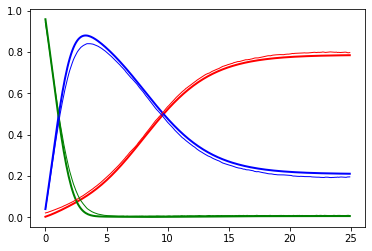

In [30]:
# Plotting of the graphs


plt.plot(t_an, i_an, linewidth=2, color='r')
plt.plot(t_an, s_an, linewidth=2, color='g')
plt.plot(t_an, a_an, linewidth=2, color='b')

plt.plot(t, i_mon, linewidth=1, color='r')
plt.plot(t, s_mon, linewidth=1, color='g')
plt.plot(t, a_mon, linewidth=1, color='b')
plt.show()

## Barabasi Albert

In [36]:
N = 320
p = int(N * 0.4)  # probability of connection
G = nx.generators.random_graphs.barabasi_albert_graph(N, p)
adj = nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).todense()
adj_matrix = nx.to_numpy_matrix(G, nodelist=[i for i in range(N)])

In [13]:
p = 0.05  # probability of negative connection
adj_matrix = my_matrix(p, adj_matrix, N)
k_plus, k_minus = my_separate(adj_matrix)
transition_matrix = transition_random_walk(k_plus, k_minus, adj_matrix)

In [37]:
analytical = np.zeros((250, 13))
monteCarlo = np.zeros((250, 13))
kappa = [0.1, 0.2, 0.3, 0]
index = 0
for value in kappa:
    params = {'beta_0': 0.01, 'beta_alpha': 0.005, 'kappa': 5, 'delta': 0.1}
    params['kappa'] = value
    t_an, i_an, s_an, a_an = solve(param=params, N=N, adj_matrix=adj_matrix, q=int(N*0.2), draw=False)
    t_mon, i_mon, s_mon, a_mon = MonteCarlo(param=params, N=N, adj_matrix=adj_matrix, q=int(N * 0.2), draw=False, Nsim=50)
    analytical[:, index] = i_an
    analytical[:, index + 1] = s_an
    analytical[:, index + 2] = a_an
    monteCarlo[:, index] = i_mon
    monteCarlo[:, index + 1] = s_mon
    monteCarlo[:, index + 2] = a_mon
    index += 3

analytical[:, 12] = t_an
monteCarlo[:, 12] = t_mon

NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
NO. of simulation: 31
NO. of simulation: 32
NO. of simulation: 33
NO. of simulation: 34
NO. of simulation: 35
NO. of simulation: 36
NO. of simulation: 37
NO. of simulation: 38
NO. of simulation: 39
NO. of simulation: 40
NO. of simulation: 41
NO. of simulation: 42
NO. of simulation: 43
NO. of simulation: 44
NO. of simulation: 45
NO. of simulation: 

<ipython-input-9-8ffa05c4cf68>:32: RuntimeWarning: overflow encountered in double_scalars
  return beta_0 * (1 - I - A) * sum1 + beta_alpha * A * sum1 - delta * I
<ipython-input-9-8ffa05c4cf68>:32: RuntimeWarning: invalid value encountered in double_scalars
  return beta_0 * (1 - I - A) * sum1 + beta_alpha * A * sum1 - delta * I
<ipython-input-9-8ffa05c4cf68>:35: RuntimeWarning: overflow encountered in double_scalars
  return kappa * (1 - I - A) * sum1 - beta_alpha * A * sum1


NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
NO. of simulation: 31
NO. of simulation: 32
NO. of simulation: 33
NO. of simulation: 34
NO. of simulation: 35
NO. of simulation: 36
NO. of simulation: 37
NO. of simulation: 38
NO. of simulation: 39
NO. of simulation: 40
NO. of simulation: 41
NO. of simulation: 42
NO. of simulation: 43
NO. of simulation: 44
NO. of simulation: 45
NO. of simulation: 

<ipython-input-9-8ffa05c4cf68>:47: RuntimeWarning: invalid value encountered in double_scalars
  a[i][1] += (kr1 + 2 * kr2 + 2 * kr3 + kr4) * h / 6
<ipython-input-9-8ffa05c4cf68>:29: RuntimeWarning: invalid value encountered in double_scalars
  sum1 += adj_matrix.item((i, j)) * a[j][0]


NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
NO. of simulation: 31
NO. of simulation: 32
NO. of simulation: 33
NO. of simulation: 34
NO. of simulation: 35
NO. of simulation: 36
NO. of simulation: 37
NO. of simulation: 38
NO. of simulation: 39
NO. of simulation: 40
NO. of simulation: 41
NO. of simulation: 42
NO. of simulation: 43
NO. of simulation: 44
NO. of simulation: 45
NO. of simulation: 

In [48]:
save_data(analytical, "BA_analytical.dat")
save_data(monteCarlo, "BA_monteCarlo.dat")

## Wattz Strogatz

In [24]:
N = 320 
p = 0.5  # The probability of rewiring each edge
k = int(N * 0.4) # Each node is connected to k nearest neighbors in ring topology
G = nx.watts_strogatz_graph(N, k, p)
adj = nx.adjacency_matrix(G, nodelist=sorted(G.nodes())).todense()
adj_matrix = nx.to_numpy_matrix(G, nodelist=[i for i in range(N)])

In [25]:
p = 0.05  # probability of negative connection
adj_matrix = my_matrix(p, adj_matrix, N)
k_plus, k_minus = my_separate(adj_matrix)
transition_matrix = transition_random_walk(k_plus, k_minus, adj_matrix)

In [26]:
analytical = np.zeros((250, 13))
monteCarlo = np.zeros((250, 13))
beta_0 = [0.1, 0.3, 0.5, 0]
index = 0
for value in beta_0:
    params = {'beta_0': 0.01, 'beta_alpha': 0.005, 'kappa': 5, 'delta': 0.1}
    params['kappa'] = value
    t_an, i_an, s_an, a_an = solve(param=params, N=N, adj_matrix=transition_matrix, q=int(N*0.02), draw=False)
    t_mon, i_mon, s_mon, a_mon = MonteCarlo(param=params, N=N, adj_matrix=transition_matrix, q=int(N * 0.02), draw=False, Nsim=30)
    analytical[:, index] = i_an
    analytical[:, index + 1] = s_an
    analytical[:, index + 2] = a_an
    monteCarlo[:, index] = i_mon
    monteCarlo[:, index + 1] = s_mon
    monteCarlo[:, index + 2] = a_mon
    index += 3

analytical[:, 12] = t_an
monteCarlo[:, 12] = t_mon

NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of

In [75]:
save_data(analytical, "WS_analytical.dat")
save_data(monteCarlo, "WS_monteCarlo.dat")

# The model with given data (not synthetic)

## "US Congress signed network" H94

In [23]:
df = pd.read_csv("Congress.txt", delimiter="\t", header=None) 

matrix = df.to_numpy()

matrix = matrix.astype('float64')

m, n = matrix.shape

matrix = np.matrix(matrix)

k_plus, k_minus = my_separate(matrix)

transition_matrix = transition_random_walk(k_plus, k_minus, matrix)

In [47]:
kappa = 1
incr = 0.1
scores = dict()
N = m
while kappa <= 5.1:
    params = {'beta_0': 3, 'beta_alpha': 1, 'kappa': kappa, 'delta': 1}
    t_an, i_an, s_an, a_an = solve(param=params, N=N, adj_matrix=transition_matrix, q=int(N*0.02), draw=False)
    t_mon, i_mon, s_mon, a_mon = MonteCarlo(param=params, N=N, adj_matrix=transition_matrix, q=int(N * 0.02), draw=False, Nsim=30)
    score_i = np.square(i_mon - i_an) / 250
    score_s = np.square(s_mon - s_an) / 250
    score_a = np.square(a_mon - a_an) / 250
    scores[kappa] = [score_i, score_s, score_a]
    print("---------------------Finished for kappa = {}------------------------".format(kappa))
    kappa += incr

NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 1------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. 

NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 2.100000000000001------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO.

NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 3.200000000000002------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
N

NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 4.300000000000002------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 4.4

NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 5.399999999999998------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 5.499999999999997------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of sim

NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 6.599999999999993------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of sim

NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 7.6999999999999895------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO

NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 8.799999999999986------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
N

NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 9.899999999999983------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
N

NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 10.999999999999979------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of simulation: 5
NO. of simulation: 6
NO. of simulation: 7
NO. of simulation: 8
NO. of simulation: 9
NO. of simulation: 10
NO. of simulation: 11
NO. of simulation: 12
NO. of simulation: 13
NO. of simulation: 14
NO. of simulation: 15
NO. of simulation: 16
NO. of simulation: 17
NO. of simulation: 18
NO. of simulation: 19
NO. of simulation: 20
NO. of simulation: 21
NO. of simulation: 22
NO. of simulation: 23
NO. of simulation: 24
NO. of simulation: 25
NO. of simulation: 26
NO. of simulation: 27
NO. of simulation: 28
NO. of simulation: 29
NO. of simulation: 30
---------------------Finished for kappa = 11.099999999999978------------------------
NO. of simulation: 1
NO. of simulation: 2
NO. of simulation: 3
NO. of simulation: 4
NO. of 

KeyboardInterrupt: 

In [82]:
# Saving analytical and MonteCarlo solutions
analytical.tofile("RealData_analytical_Optimized.dat")
monteCarlo.tofile("RealData_monteCarlo_Optimized.dat")

In [42]:
# Loading data
an1 = np.fromfile("RealData_analytical.dat", dtype=float)
mn = np.fromfile("RealData_monteCarlo.dat", dtype=float)

In [61]:
an1 = np.reshape(an1, (analytical.shape[0], analytical.shape[1]))

In [13]:
def visualize_data(analytical, monteCarlo, varying_parameters=[1, 2, 3], title='The graph', step=5, start=0, end=None):
    # Visualization
    # shape = 250, 13; 
    # [0, 3, 6, 9] -> infection density; [1, 4, 7, 10] -> susc. density; [2, 5, 8, 11] -> alert. 
    # Note: Last indexes (9, 10, 11) for SIS model
    # I want the plot with plts (1, 2) displaying infection and alert density 

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))  # Draw infection, sus, alert
    inf, sus, alert, sis = 0, 1, 2, 9  # Starting indexes of each state 
    states = [inf, sus, alert]
    row, columns = analytical.shape
    time_analytical = analytical[:, columns - 1]
    time_monte = monteCarlo[:, columns - 1]
    if end is None:
        end = row + 1

    # fig.supxlabel("time (s)")
    index_sis = 0
    titles_of_axis = ['Infection density', 'Susceptible density', 'Alert density']
    kappa_values = varying_parameters
    markers = ['x', '+', 'D']
    colors = ['r', 'g', 'y']
    for ax, state in zip(axs.flat, states):
        for index in range(3):
            ax.scatter(time_analytical[start:end:step], 
                              analytical[:, state + (index * 3)][start:end:step], 
                              marker=markers[index], linewidth=2, color=colors[index], 
                              label=r'$\kappa$={}'.format(kappa_values[index]))
            ax.plot(time_monte[start:end:step], monteCarlo[:, state + (index * 3)][start:end:step], color='b', linewidth=1)

        ax.plot(time_analytical[start:end:step], analytical[:, sis + index_sis][start:end:step], 
                color='m', linewidth=2, label="SIS")
        ax.plot(time_monte[start:end:step], monteCarlo[:, sis + index_sis][start:end:step], color='b', linewidth=1)
        ax.set(ylabel=titles_of_axis[index_sis])
        index_sis += 1
        

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(lines_labels[0])]
    fig.legend(lines, labels)
    fig.suptitle(title, fontsize=16)
    plt.show()

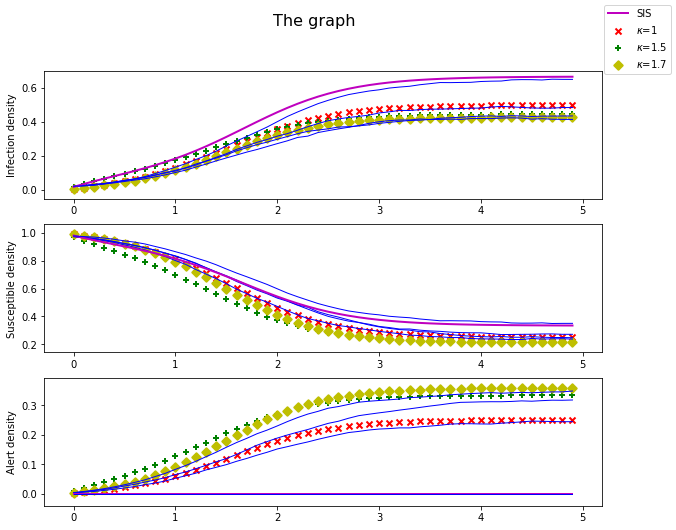

In [84]:
shape = (250, 13)
analytical_real = load_data("RealData_analytical_Optimized.dat", shape=shape, dtype=float)
monteCarlo_real = load_data("RealData_monteCarlo_Optimized.dat", shape=shape, dtype=float)
visualize_data(analytical=analytical_real, monteCarlo=monteCarlo_real, varying_parameters=[1, 1.5, 1.7], end=50, step=1)